In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import img_utils

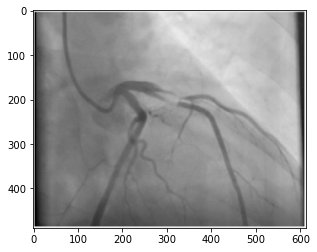

In [2]:
#Step 1 load image
image_path = '../sample-images/disease.png' #change this path to see results for another image
original_img = cv2.imread(image_path)
plt.imshow(original_img)
plt.show()

Old Dimensions (613,489)
New Dimensions (491,393)


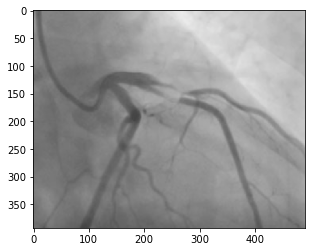

In [3]:
#Step 2 Crop image borders by 10%
print(f'Old Dimensions ({original_img.shape[1]},{original_img.shape[0]})')
x_new = int(original_img.shape[1] * .1)
y_new = int(original_img.shape[0] * .1)
img_cropped = original_img[y_new:original_img.shape[0] - y_new, x_new: original_img.shape[1] - x_new]
print(f'New Dimensions ({img_cropped.shape[1]},{img_cropped.shape[0]})')
plt.imshow(img_cropped)
plt.show()

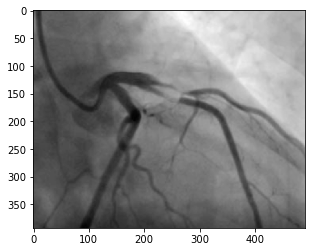

In [4]:
#Step 3 convert image to gray
gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray')
plt.show()

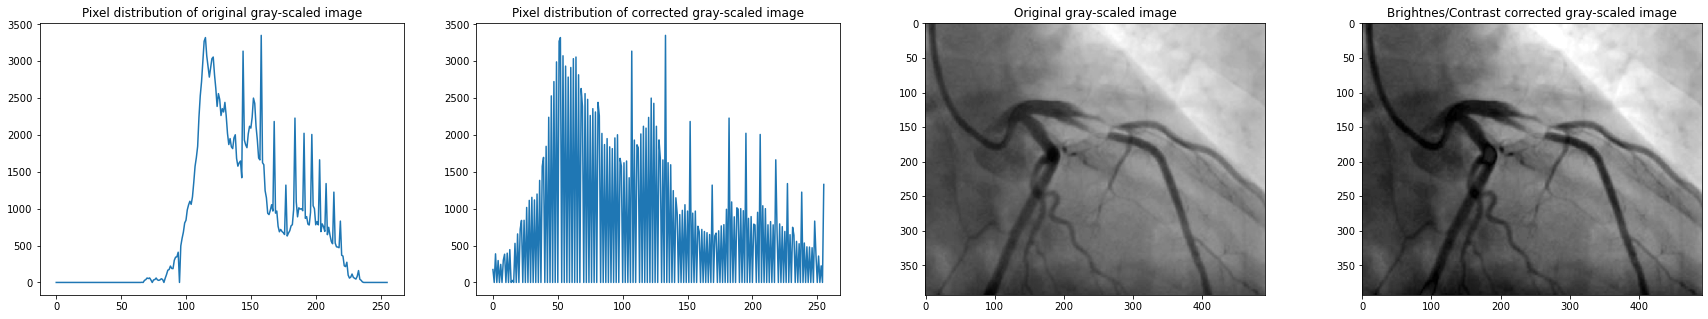

In [5]:
#Step 4 - Apply brightness correction to gray scaled image
original_hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
gray_corrected = img_utils.automatic_brightness_and_contrast(gray)
new_hist = cv2.calcHist([gray_corrected], [0], None, [256], [0, 256])
fig, ax = plt.subplots(1, 4, figsize = (30,5))
ax[0].plot(original_hist)
ax[0].set_title('Pixel distribution of original gray-scaled image')
ax[1].plot(new_hist)
ax[1].set_title('Pixel distribution of corrected gray-scaled image')
ax[2].imshow(gray, cmap = 'gray')
ax[2].set_title('Original gray-scaled image')
ax[3].imshow(gray_corrected, cmap = 'gray')
ax[3].set_title('Brightnes/Contrast corrected gray-scaled image')
plt.show()

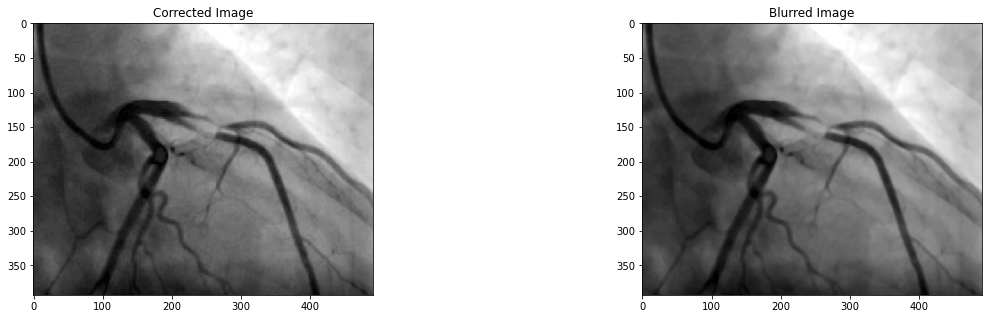

In [6]:
#Step 5 Blur the image to reduce noise
fig, ax = plt.subplots(1,2, figsize = (20,5))
blurred = cv2.medianBlur(gray_corrected, 5)
ax[0].imshow(gray_corrected, cmap = 'gray')
ax[0].set_title('Corrected Image')
ax[1].imshow(blurred, cmap = 'gray')
ax[1].set_title('Blurred Image')
plt.show()

Block Size of 33
Block size for the adaptive threshold algorithm.  This will use 33 blocks, each containing a neighborhood of 12 pixels


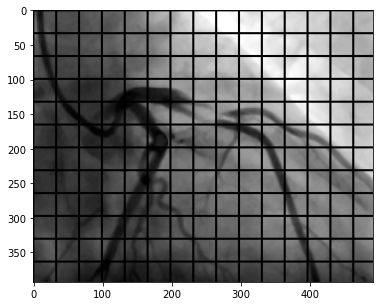

In [7]:
#Step 6 Create blocksize
neighbors = 12
blurred_copy = blurred.copy()
block_size = int(blurred.shape[0] / neighbors)
block_size = block_size + 1 if block_size % 2 == 0 else block_size #ensure that block size is odd number
print(f'Block Size of {block_size}')
for y in range(0, blurred.shape[0], block_size):
    for x in range(0, blurred.shape[1], block_size):
        cv2.rectangle(blurred_copy, (x, y), (x+block_size, y+block_size), (0,0,255), 2)
print(f'Block size for the adaptive threshold algorithm.  This will use {block_size} blocks, each containing a neighborhood of {neighbors} pixels')
plt.figure(figsize=(20,5))
plt.imshow(blurred_copy, cmap = 'gray')
plt.show()

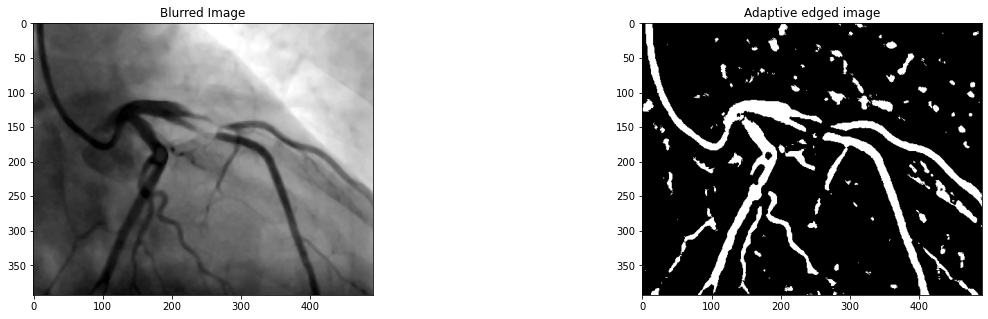

In [8]:
#Step 7 Apply adaptive thresholding using the block size above
constant = 10
edged_adap = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, block_size, constant)
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ax[0].imshow(blurred, cmap = 'gray')
ax[0].set_title('Blurred Image')
ax[1].imshow(edged_adap, cmap = 'gray')
ax[1].set_title('Adaptive edged image')
plt.show()

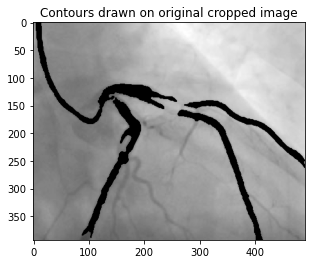

In [9]:
#Step 8, get contours
min_contour_area = 1250 #minimum area allowed for each contour - this is meant to reduce noise
thresh = cv2.morphologyEx(edged_adap, cv2.MORPH_ELLIPSE, np.ones((3,3), np.uint8))
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = [i for i in contours if cv2.contourArea(i) > min_contour_area]
edged_contour = img_cropped.copy()
for idx, c1 in enumerate(contours): 
    cv2.drawContours(edged_contour, [c1], -1, (0,0,0), -1)
edged_contour = cv2.cvtColor(edged_contour, cv2.COLOR_BGR2GRAY)
plt.imshow(edged_contour, cmap = 'gray')
plt.title('Contours drawn on original cropped image')
plt.show()
#find contours
# contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL)

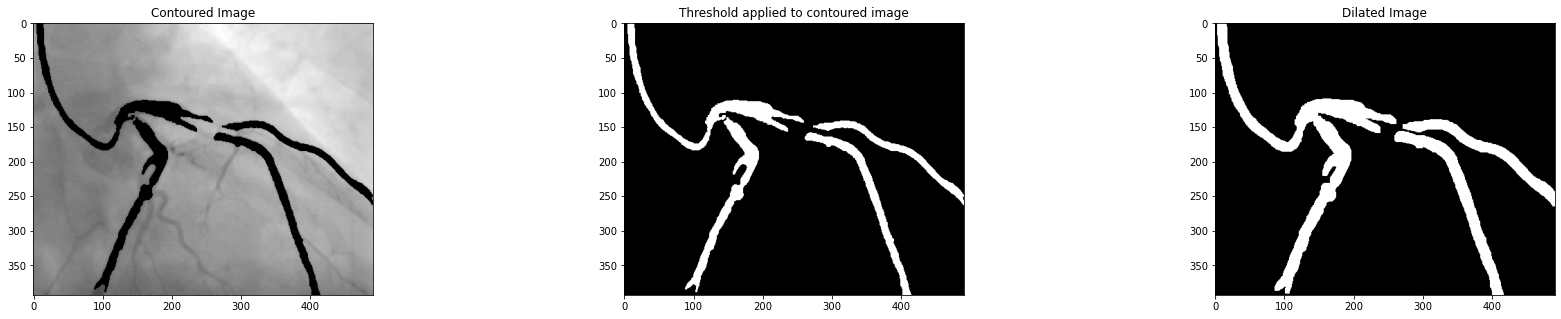

In [10]:
#Step 9 Perform another round of threshold to include only the contoured areas then dilate the image to reduce the space between contours
threshed = cv2.threshold(edged_contour, 0, 255, cv2.THRESH_BINARY_INV)[1]
dilated = cv2.dilate(threshed, None, iterations = 2)
fig, ax = plt.subplots(1,3, figsize=(30,5))
ax[0].imshow(edged_contour, cmap = 'gray')
ax[0].set_title('Contoured Image')
ax[1].imshow(threshed, cmap = 'gray')
ax[1].set_title('Threshold applied to contoured image')
ax[2].imshow(dilated, cmap = 'gray')
ax[2].set_title('Dilated Image')
plt.show()

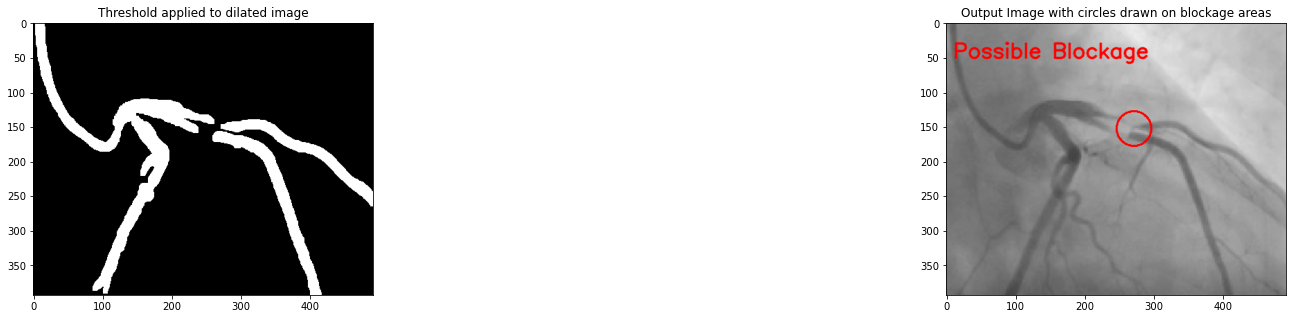

In [11]:
#Step 10 Another contour operation to get outlines of the dilated image.  
min_contour_area = 1250
output_image = img_cropped.copy()
thresh = cv2.morphologyEx(dilated, cv2.MORPH_ELLIPSE, np.ones((3,3), np.uint8))
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contours = [i for i in contours if cv2.contourArea(i) > min_contour_area]
detections = 0
for idx1, c1 in enumerate(contours):
    for idx2, c2 in enumerate(contours):
        if idx2 == idx1:
            continue
        point = img_utils.find_if_close(c1, c2, min_dist = 10)
        if point: 
            detections += 1
            center = tuple(contours[idx1][point].squeeze())
            cv2.circle(output_image, center, 25, (0,0,255), 2)

message = f'Possible Blockage' if detections > 0 else 'No Blockage Detected'
color = (0, 0, 255) if detections > 0 else (0, 255, 0)
output_image = cv2.putText(output_image, message, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax[0].imshow(thresh, cmap = 'gray')
ax[0].set_title('Threshold applied to dilated image')
ax[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
ax[1].set_title('Output Image with circles drawn on blockage areas')
plt.show()